西安市气象数据爬取与分析-8组-禹诗雨

一、数据爬取+存储

In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import json

In [2]:
def getHTMLtext(url):
    try:
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        r.encoding = r.apparent_encoding
        print("成功访问")
        return r.text
    except:
        print("访问错误")
        return " "


def get_content(html):
    final = []
    bs = BeautifulSoup(html, "html.parser")
    body = bs.body
    data = body.find('div', {'id': '7d'})
    # 下面爬取当天的数据
    data2 = body.find_all('div', {'class': 'left-div'})
    text = data2[2].find('script').string
    text = text[text.index('=') + 1:-2]
    jd = json.loads(text)
    dayone = jd['od']['od2']
    final_day = []
    count = 0
    for i in dayone:
        temp = []
        if count <= 23:
            temp.append(i['od21'])  # 添加时间
            temp.append(i['od22'])  # 添加当前时刻温度
            temp.append(i['od24'])  # 添加当前时刻风力方向
            temp.append(i['od25'])  # 添加当前时刻风级
            temp.append(i['od26'])  # 添加当前时刻降水量
            temp.append(i['od27'])  # 添加当前时刻相对湿度
            temp.append(i['od28'])  # 添加当前时刻控制质量
            # print(temp)
            final_day.append(temp)
        count = count + 1
    # 下面爬取7天的数据
    ul = data.find('ul')
    li = ul.find_all('li')
    i = 0
    for day in li:
        if i < 7 and i > 0:
            temp = []
            date = day.find('h1').string
            date = date[0:date.index('日')]
            temp.append(date)
            inf = day.find_all('p')
            temp.append(inf[0].string)

            tem_low = inf[1].find('i').string

            if inf[1].find('span') is None:
                tem_high = None
            else:
                tem_high = inf[1].find('span').string
            temp.append(tem_low[:-1])
            if tem_high[-1] == '℃':
                temp.append(tem_high[:-1])
            else:
                temp.append(tem_high)

            wind = inf[2].find_all('span')
            for j in wind:
                temp.append(j['title'])

            wind_scale = inf[2].find('i').string
            index1 = wind_scale.index('级')
            temp.append(int(wind_scale[index1 - 1:index1]))
            final.append(temp)
        i = i + 1
    return final_day, final

# print(final)
def get_content2(html):
    final = []
    bs = BeautifulSoup(html, "html.parser")
    body = bs.body
    data = body.find('div', {'id': '15d'})
    ul = data.find('ul')
    li = ul.find_all('li')
    final = []
    i = 0
    for day in li:
        if i < 8:
            temp = []
            date = day.find('span', {'class': 'time'}).string
            date = date[date.index('（') + 1:-2]
            temp.append(date)
            weather = day.find('span', {'class': 'wea'}).string
            temp.append(weather)
            tem = day.find('span', {'class': 'tem'}).text
            temp.append(tem[tem.index('/') + 1:-1])
            temp.append(tem[:tem.index('/') - 1])
            wind = day.find('span', {'class': 'wind'}).string
            if '转' in wind:
                temp.append(wind[:wind.index('转')])
                temp.append(wind[wind.index('转') + 1:])
            else:
                temp.append(wind)
                temp.append(wind)
            wind_scale = day.find('span', {'class': 'wind1'}).string
            index1 = wind_scale.index('级')
            temp.append(int(wind_scale[index1 - 1:index1]))

            final.append(temp)
    return final


def write_to_csv(file_name, data, day=14):
    with open(file_name, 'a', errors='ignore', newline='') as f:
        if day == 14:
            header = ['日期', '天气', '最低气温', '最高气温', '风向1', '风向2', '风级']
        else:
            header = ['小时', '温度', '风力方向', '风级', '降水量', '相对湿度', '空气质量']
        f_csv = csv.writer(f)
        f_csv.writerow(header)
        f_csv.writerows(data)


def main():
    """主函数"""
    print("Weather test")
    #西安市
    url1 = 'http://www.weather.com.cn/weather/101110101.shtml'
    url2 = 'http://www.weather.com.cn/weather15d/101110101.shtml'

    html1 = getHTMLtext(url1)
    data1, data1_7 = get_content(html1)

    html2 = getHTMLtext(url2)
    data8_14 = get_content2(html2)
    data14 = data1_7 + data8_14
    # print(data)
    write_to_csv('./data/weather14.csv', data14, 14)
    write_to_csv('./data/weather1.csv', data1, 1)

In [3]:
if __name__ == '__main__':
    main()

Weather test
成功访问
成功访问


二、可视化分析

In [4]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

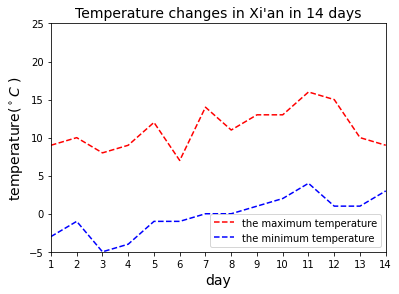

In [5]:
# 高低温变化图

data = pd.read_csv('data/weather14.csv', encoding='gb2312')

record_min = data['最低气温'].to_numpy()
record_max = data['最高气温'].to_numpy()

plt.figure(figsize=(6, 4.2))
plt.plot(np.arange(len(record_max)) + 1,record_max, '--k', color="red", label="the maximum temperature")
plt.plot(np.arange(len(record_max)) + 1,record_min, '--k', color="blue", label="the minimum temperature")

plt.xlim(1, 14)
plt.xticks(list(range(1, 15)))
plt.ylim(-5, 25)
plt.xlabel('day', size=14)
plt.ylabel('temperature($^\circ C$ )',size=14)

plt.title('Temperature changes in Xi\'an in 14 days',size=14)
plt.legend(loc=4)

plt.show()

In [7]:
data = pd.read_csv('data/weather1.csv', encoding='gb2312')

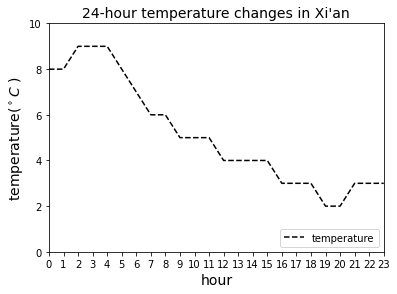

In [8]:
# 温度

temp = data['温度'].to_numpy()

plt.figure(figsize=(6, 4.2))
plt.plot(np.arange(len(temp)), temp, '--k', label="temperature")

plt.xlim(0, 23)
plt.xticks(list(range(0, 24)))
plt.ylim(0, 10)
plt.xlabel('hour', size=14)
plt.ylabel('temperature($^\circ C$ )', size=14)

plt.title('24-hour temperature changes in Xi\'an',size=14)
plt.legend(loc=4)

plt.show()

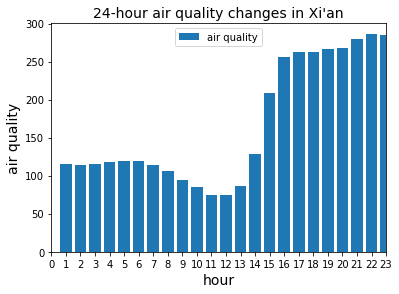

In [10]:
# 空气质量指数

hum = data['空气质量'].to_numpy()

plt.figure(figsize=(6, 4.2))
plt.bar(np.arange(len(hum)), hum, label="air quality")

plt.xlim(0, 23)
plt.xticks(list(range(0, 24)))
plt.xlabel('hour', size=14)
plt.ylabel('air quality', size=14)

plt.title('24-hour air quality changes in Xi\'an',size=14)
plt.legend(loc=0)

plt.show()